##### Copyright 2020 Google

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fermi-Hubbard experiment example

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.example.org/cirq/experiments/fermi_hubbard/experiment_example"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on QuantumLib</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/ReCirq/blob/master/docs/fermi_hubbard/experiment_example.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/ReCirq/blob/master/docs/fermi_hubbard/experiment_example.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/ReCirq/docs/fermi_hubbard/experiment_example.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook demonstrates how to define, execute, and plot the results of a single instance of [the Fermi-Hubbard experiment](https://arxiv.org/abs/2010.07965). We show how to run the experiment using a Cirq simulator and a quantum processor through Google's Quantum Computing Service.

The Fermi-Hubbard model on a one-dimensional lattice of $L$ sites with open boundary conditions is defined by the Hamiltonian

$$
H = - J \sum_{j = 1}^{L - 1} \sum_{\nu = \uparrow, \downarrow} c_{j, \nu}^\dagger c_{j + 1, \nu} + \text{h.c.} + U \sum_{j = 1}^{L} n_{j, \uparrow} n_{j, \downarrow} + \sum_{j = 1}^{L} \sum_{\nu = \uparrow, \downarrow} \epsilon_{j, \nu} n_{j, \nu} 
$$

where $c_{j, \nu}$ ($c_{j, \nu}^\dagger$) are the fermionic annihilation (creation) operators associated to site number $j$ and spin state $\nu$, and $n_{j, \nu} = c_{j, \nu}^\dagger c_{j, \nu}$ are the number operators. The *hopping term* with coefficient $J$ describes particles tunneling between neighboring sites, the *onsite interaction term* with coefficient $U$ introduces an energy difference for doubly occupied sites, and the term $\epsilon_{j, \nu}$ represents spin-dependent local potentials. 

Our goal in this experiment is to compute the charge and spin densities which are defined as the sum and difference of the spin-up and spin-down particle densities, respectively

$$
\rho_{j}^{\pm} = \langle n_{j, \uparrow} \rangle \pm \langle n_{j, \downarrow} \rangle,
$$

after simulating the Fermi-Hubbard model for some evolution time.

## Setup

We first install ReCirq which contains code for running Fermi-Hubbard experiments.

In [2]:
try:
    import recirq
except ImportError:
    print("Installing ReCirq...")
    !pip install git+https://github.com/quantumlib/recirq --quiet
    print("Installed ReCirq!")

To track the progress of simulating experiments, we use the `tqdm` package.

In [3]:
try:
    import ipywidgets
except ImportError:
    !pip install ipywidgets --quiet
    !jupyter nbextension enable --py widgetsnbextension --sys-prefix

We can now import Cirq and the `fermi_hubbard` module from ReCirq.

In [4]:
import cirq

from recirq import fermi_hubbard
from recirq.fermi_hubbard import publication

# Hide numpy warnings
import warnings
warnings.filterwarnings("ignore")

## Experiment parameters

The first step is to decide on exact experiment parameters including problem Hamiltonian, initial state description, as well as a mapping from fermions to qubits on the device. Once we have this information, we can create circuits and run the experiment.

### Qubit layout

We will simulate the Fermi-Hubbard model on $L = 8$ sites. Each site is represented by two qubits due to the two spin states, so we need a total of $16$ qubits to simulate the experiment.

The function `rainbow23_layouts` returns a set of $16$-qubit subgrids of the Google Rainbow processor. 

> *Note*: We use multiple layouts to average results over different qubit assignments. One the quantum processor, this cancels some of the statistical errors which occur from calibration to calibration.

In [5]:
"""Get all layouts for 8 sites on a 23-qubit subgrid of the Google Rainbow processor."""
layouts = publication.rainbow23_layouts(sites_count=8)
print(f"There are {len(layouts)} total qubit layouts.")

There are 16 total qubit layouts.


We can see an example layout by printing out its text diagram.

In [6]:
"""Display an example layout."""
print(layouts[0].text_diagram())

1↓ (4, 1)━━━1↑ (4, 2)
│           │
│           │
2↓ (5, 1)━━━2↑ (5, 2)───3↑ (5, 3)
│                       │
│                       │
3↓ (6, 1)───4↓ (6, 2)━━━4↑ (6, 3)───5↑ (6, 4)
            │                       │
            │                       │
            5↓ (7, 2)───6↓ (7, 3)━━━6↑ (7, 4)───7↑ (7, 5)
                        │                       │
                        │                       │
                        7↓ (8, 3)───8↓ (8, 4)━━━8↑ (8, 5)


The layout indicates the site index $j$ and spin state $\nu$, as well as which `cirq.GridQubit` on the Rainbow processor this combination of $(j, \nu)$ is encoded into. One can choose a different layout in the previous cell to see how the configurations vary.

### Problem parameters

Let's use the Hamiltonian with uniform $J = 1$ and $U = 2$ on each site, initial state prepared as a ground state of a non-interacting Hamiltonian with trapping potential of a Gaussian shape, Trotter step size equal to 0.3, and two particles per chain. The problem parameters with this initial state can be prepared with the pre-defined function `trapping_instance`.

In [7]:
"""Get FermiHubbardParameters (problem descriptions) for each qubit layout with the above parameters."""
parameters = [
    publication.trapping_instance(
        layout, u=2, dt=0.3, up_particles=2, down_particles=2
    ) 
    for layout in layouts
]

> Other configurations can be prepared by creating instances of the `fermi_hubbard.FermiHubbardParameters` data class explicitly.

The results are instances of the `FermiHubbardParameters` data class for each layout. This data class uniquely defines the configuration to run and contains information such as the Hamiltonian, initial state, layout, and time step. Below, we display these values for an example element of `parameters`.

In [8]:
"""Display the Hamiltonian for an example problem description."""
parameters_example = parameters[0]
print(parameters_example.hamiltonian)

Hamiltonian(sites_count=8, j=1.0, u=2, v=0, local_charge=0, local_spin=0, mu_up=0, mu_down=0)


We can also see the initial state:

In [9]:
parameters_example.initial_state

IndependentChainsInitialState(up=GaussianTrappingPotential(particles=2, center=0.5, sigma=0.14285714285714285, scale=-4), down=UniformTrappingPotential(particles=2))

And the time step:

In [10]:
parameters_example.dt

0.3

## Circuits

One can directly run an experiment from a `FermiHubbardParameters` instance (which we will do in the next section). However, it is illustrative to construct the circuits to see how the Fermi-Hubbard execution works.

### Circuit creation

To create a circuit from a description of a problem, the function `fermi_hubbard.create_circuits` can be used. This function inputs a `FermiHubbardParameters` instance (i.e., a problem description) and number of Trotter steps. It returns circuits for constructing the initial state, simulating time-evolution via a number of Trotter steps, and measuring to compute observables.

In [11]:
"""Create circuits from a problem description."""
initial, trotter, measurement = fermi_hubbard.create_circuits(parameters_example, trotter_steps=1)

Below, we display the complete circuit to execute which is a sum of the three component circuits above.

In [12]:
"""Display the total circuit to execute."""
circuit = initial + trotter + measurement
circuit

┌────────────────────────────────────────┐         ┌────────────────────────────────────────┐         ┌─────────────────────────────────────────┐         ┌──────────────────────────────────────────┐         ┌────────────────────────────────────────┐         ┌─────────────────────────────────────────┐         ┌─────────────────────────────────────────┐         ┌──────────────────────────────────┐                ┌────────────────────────────┐                ┌────────────────────────────────┐
(4, 1): ───X───────────────────────────────────────────────────────────────────────────PhISwap(0.25)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────FSim(-0.0955π, 0)────CPhaseEcho────────────────────────────────────@─────────────────────────────────────────────────────M────────
                                                                                       │                                                                                                                                                                                                                                                                                                                   │                                                                  │                                                     │
(4, 2): ───X───────────────────────────────────────────────────────PhISwap(0.25)───────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────FSim(-0.0955π, 0)┼────────────────────CPhaseEcho────────────────────────────────────@^-0.191──────────────────────────────────────────────M('z')───
                                                                   │                   │                                                                                                                                                                                                                                                                                                  │                │                                                                                                                        │
(5, 1): ───X────────────────────────PhISwap(0.25)──────────────────┼───────────────────PhISwap(0.25)^-0.816────Z^0────────────────────────PhISwap(0.25)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────FSim(-0.0955π, 0)────@───────────────────────────FSim(-0.5π, 0)────@─────────────────────────────FSim(-0.595π, 0)────Z───M────────
                                    │                              │                                                                      │                                                                                                                                                                                                                                               │                                     │                           │                 │                             │                       │
(5, 2): ───X────PhISwap(0.25)───────┼──────────────────────────────PhISwap(0.25)^-0.988────────────────────────Z^0────PhISwap(0.25)───────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

> *Note*: For a deeper explanation of these circuits and the gates used in them, see the [Fermi-Hubbard experiment paper](https://arxiv.org/abs/2010.07965).

### Circuit decomposition

The circuit above is constructed using gates which are not native to Google hardware, for example `cirq.FSim` or `cirq.CZ` with arbitrary exponent. To run these circuits on Google hardware, we have to convert them into native operations. For the Fermi-Hubbard experiment, a special converter called `ConvertToNonUniformSqrtIswapGates` is provided.

This converter has the ability to decompose gates to $\sqrt{\small \mbox{iSWAP}}$ both perfectly (i.e., without noise) and with unitary parameters deviating from the perfect ones and varying between qubit pairs. The function `ideal_sqrt_iswap_converter` creates an instance of the noiseless converter which decomposes $\sqrt{\small \mbox{iSWAP}}$ gates exactly as `cirq.FSim(π/4, 0)`. The function `google_sqrt_iswap_converter` creates an instance of the noisy converter which approximates the average values on Rainbow processor (which are about `cirq.FSim(π/4, π/24)` on each two-qubit pair).

Below we show an example of the perfect decomposition into the $\sqrt{\small \mbox{iSWAP}}$ gate set.

In [13]:
"""Convert the circuit to native hardware gates perfectly (without noise)."""
publication.ideal_sqrt_iswap_converter().convert(circuit)

┌────────────────────┐             ┌────────────────────┐          ┌────────────────────┐             ┌────────────────────┐          ┌────────────────────┐             ┌────────────────────┐          ┌────────────────────┐               ┌────────────────────┐          ┌────────────────────┐              ┌────────────────────┐          ┌────────────────────┐               ┌────────────────────┐       ┌────────────────────┐               ┌────────────────────┐             ┌────────────────────┐             ┌────────────────────┐                                                                                                ┌────────────────────┐       ┌────────────────────┐                                                                                                  ┌────────────────────┐             ┌────────────────────┐
(4, 1): ───X──────────────────────────────────────────────────────────────────────S^-1──────────────iSwap─────────Z^0.592──────────────iSwap────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────T^-1─────────────────iSwap─────────Z^0.095──────────────iSwap──────────────────────────────────────────────PhX(0.25)──────────────────────PhX(0.25)──────────────────────────────────────────────────────────────────────PhX(0.25)^0.0483───T^-1───iSwap────────Rx(-0.136π)───Z───iSwap────────Rx(-0.048π)──────────────────────────────────────────────────────────────────────────M────────
                                                                                                    │                                  │                                                                                                                                                                                                                                                                                                                                                                                     │                                  │                                                                                                                                                                                          │                              │                                                                                                 │
(4, 2): ───X──────────────────────────────────────────────────────────────────────S^-1────iSwap─────┼─────────────Z^0.506────iSwap─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────T^-1───────iSwap─────┼─────────────Z^0.095────iSwap─────┼──────────────────────────────────────────────────PhX(0.25)──────────────────────PhX(0.25)──────────────────────────────────────────────────────────────────────PhX(0.25)^0.5──────T^-1───iSwap^-0.5─────────────────────iSwap^-0.5───Rx(-0.5π)────────────────────────────────────────────────────────────────────────────M('z')───
                                                                                          │         │                        │         │                                                                                                                                                                                                                                                                                                                                                                           │         │                        │         │                 

We will consider both ideal and noisy decompositions when executing the experimt below.

## Cirq simulation

This section demonstrates how to simulate experiments using Cirq simulator. We will simulate the evolution from $0$ to $10$ Trotter steps. Physically, this corresponds to an evolution time of $t = 3 \hbar / J$.

In [14]:
"""Set the number of Trotter steps to simulate."""
trotter_steps = range(10 + 1)

### Ideal

As mentioned above, we can use the `ideal_sqrt_iswap_converter` to convert circuits perfectly into the $\sqrt{\small \mbox{iSWAP}}$ gate set. The Fermi-Hubbard project provides `ConvertingSampler` that converts circuits before executing ands sampling from them. We get an ideal sampler below.

In [15]:
"""Get an ideal sampler to simulate experiments."""
ideal_sampler = fermi_hubbard.ConvertingSampler(
    cirq.Simulator(), publication.ideal_sqrt_iswap_converter().convert
)

We can now run experiments using the `run_experiment` function. This function takes the parameters of a problem, a sampler, and a list of Trotter steps to simulate. Below, we provide the problem parameters defined on each $16$ qubit layout of the Rainbow processor and simulate the experiments using ten Trotter steps and the `ideal_sampler`.

In [16]:
"""Run the experiments on a perfect simulator for each qubit layout."""
from tqdm.notebook import tqdm

with tqdm(range(len(parameters) * len(trotter_steps))) as progress:
    experiments = [
        fermi_hubbard.run_experiment(
            params, 
            trotter_steps, 
            ideal_sampler, 
            post_run_func=lambda *_: progress.update()
        )
        for params in parameters
    ]

The output of `run_experiment` is an instance of the `ExperimentResult` data class. A series of experiments for the same problem instance on different qubit layouts can be post-processed with the help of the `InstanceBundle` class. This class takes care of averaging results over qubits layouts, re-scaling the data by comparing against a reference run (perfect simulation in this case), and extracting various quantities.

In [17]:
"""Post-process the experimental data for all qubit layouts."""
bundle = fermi_hubbard.InstanceBundle(experiments)
bundle.cache_exact_numerics()

A number of quantities of interest can be accessed from an `InstanceBundle`, as shown below.

In [18]:
"""Show quantities which can be accessed from an InstanceBundle."""
for quantity_name in bundle.quantities:
    print(quantity_name)

up_down_density
up_down_position_average
up_down_position_average_dt
up_down_spreading
up_down_spreading_dt
charge_spin_density
charge_spin_position_average
charge_spin_position_average_dt
charge_spin_spreading
charge_spin_spreading_dt
up_down_density_norescale
up_down_position_average_norescale
up_down_position_average_dt_norescale
up_down_spreading_norescale
up_down_spreading_dt_norescale
charge_spin_density_norescale
charge_spin_position_average_norescale
charge_spin_position_average_dt_norescale
charge_spin_spreading_norescale
charge_spin_spreading_dt_norescale
scaling
post_selection


These quantities can be converted to a pandas `DataFrame` using the `quantity_data_frame` function. Our main goal in simulating the Fermi-Hubbard model was to compute the charge and spin densities

$$
\rho_{j}^{\pm} = \langle n_{j, \uparrow} \rangle \pm \langle n_{j, \downarrow} \rangle .
$$

We can get a `DataFrame` for the `"charge_spin_density"` quantity as follows.

In [19]:
"""Example of getting a DataFrame from a quantity."""
charge_spin_density, _, _ = fermi_hubbard.quantity_data_frame(bundle, "charge_spin_density")
charge_spin_density.head()

,u,chain,step,time,site,value,std_error,std_dev
0,2,0,0,0.0,1,0.121107,0.000731,0.002924
1,2,0,0,0.0,2,0.330109,0.000875,0.003499
2,2,0,0,0.0,3,0.519672,0.001149,0.004598
3,2,0,0,0.0,4,1.029645,0.000811,0.003243
4,2,0,0,0.0,5,1.030587,0.001156,0.004625


This data frame contains the value, standard error, and standard deviation of the `"charge_spin_density"` quantity at each site for each time (Trotter step). For convenience, this quantity (and others) can be plotted with the `fermi_hubbard.plot_quantity` helper function.

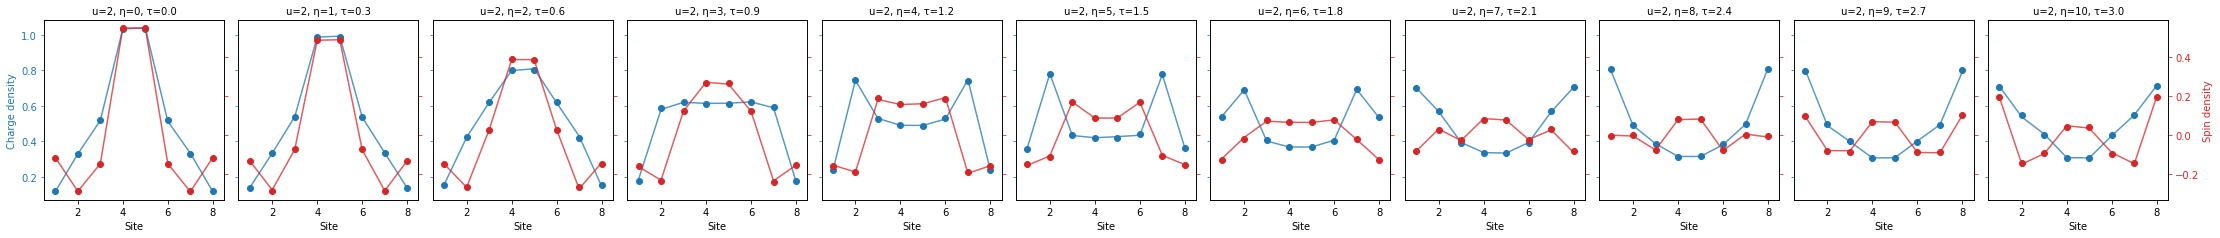

In [20]:
"""Plot the charge spin density."""
fermi_hubbard.plot_quantity(bundle, "charge_spin_density");

This plotting function automatically adjusts the appearance of plots according to the data being plotted. We illustrate this by plotting the `"charge_spin_spreading"` below.

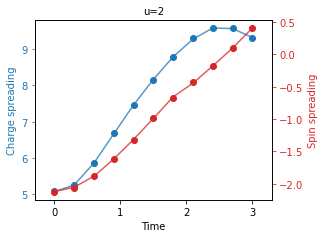

In [21]:
"""Plot the charge spin spreading."""
fermi_hubbard.plot_quantity(bundle, "charge_spin_spreading");

One can compare these plots to Figure 2 of the [Fermi-Hubbard experiment paper](https://arxiv.org/abs/2010.07965).

### Parasitic controlled-phase

We now run the same experiment but with the `google_sqrt_iswap_converter`. As mentioned, this decomposes $\sqrt{\small \mbox{iSWAP}}$ gates imperfectly as `cirq.FSim(π/4, π/24)` which is close to the average value of the parisitic controlled phase on the Rainbow processor.

In [22]:
"""Run the experiments on a noisy simulator for each qubit layout."""
parasitic_sampler = fermi_hubbard.ConvertingSampler(
    cirq.Simulator(), publication.google_sqrt_iswap_converter().convert
    )

with tqdm(range(len(parameters) * len(trotter_steps))) as progress:
    experiments = [
        fermi_hubbard.run_experiment(
            params, 
            trotter_steps, 
            parasitic_sampler, 
            post_run_func=lambda *_: progress.update()
        )
        for params in parameters
    ]

As above, we can post-process the data using an `InstanceBundle` and plot quantities of interest using the `plot_quantity` helper function.

In [23]:
"""Post-process the experimental data for all qubit layouts."""
bundle = fermi_hubbard.InstanceBundle(experiments)
bundle.cache_exact_numerics()

We first plot the `"charge_spin_density"`:

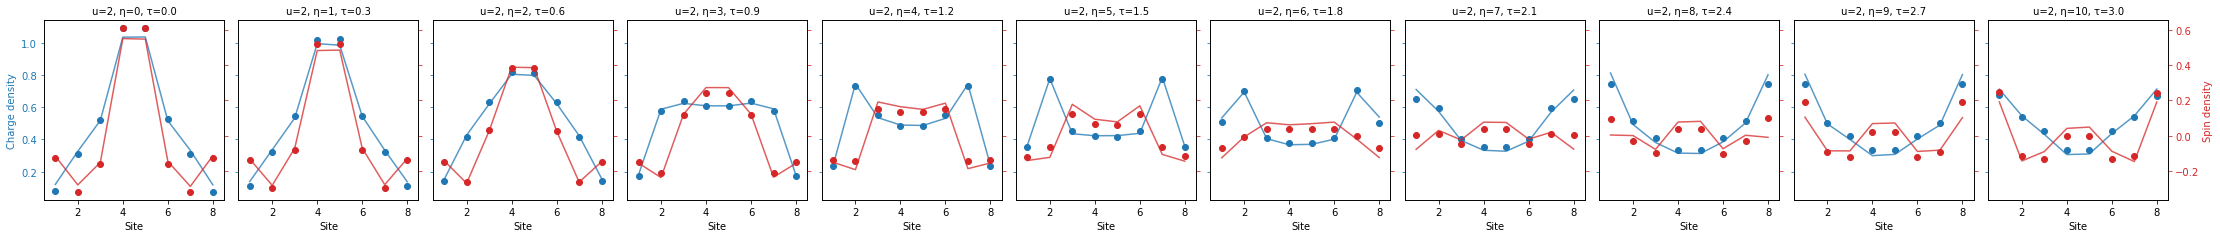

In [24]:
fermi_hubbard.plot_quantity(bundle, 'charge_spin_density');

And plot the `"charge_spin_spreading"` as well.

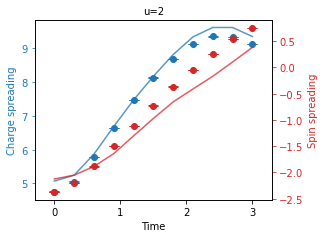

In [25]:
"""Plott the charge spin spreading."""
fermi_hubbard.plot_quantity(bundle, 'charge_spin_spreading', show_std_error=True);

One can compare these to the simulation with exact decompositions above to see the effect of the parasitic controlled phase.

# Google's Quantum Computing Service Execution

In order to run experiment on Google's QCS, a special sampler that runs circuits at Google's QCS is necessary. The script below assumes that an environment variable ```GOOGLE_CLOUD_PROJECT``` is present and set to a valid Google Cloud Platform project identifier.

In [ ]:
processor_id = 'rainbow'
engine_sampler = cirq.google.get_engine_sampler(processor_id=processor_id,
                                                gate_set_name='sqrt_iswap')
google_sampler = ConvertingSampler(engine_sampler, google_sqrt_iswap_converter().convert)

It is convenient to watch for a progress of the QCS execution. It is also good to persist the experiment results on disk as soon sa they are ready. Although rare, the remote operation might fail for various reasons and more advanced execution workflow might include error handling, experiment pause and continuation, etc.

The script below does not include Floquet calibration.

In [ ]:
results_dir = 'trapping'

with tqdm(range(len(layouts) * len(steps))) as progress:
    def post_run(_1, _2):
        progress.update()
    for index, params in enumerate(parameters):
        experiment = run_experiment(params, steps, google_sampler, post_run_func=post_run)
        save_experiment(experiment, f'{results_dir}/trapping_{index + 1}.json')

In [ ]:
experiments = [load_experiment(f'{results_dir}/trapping_{index + 1}.json') 
               for index in range(len(parameters))]

In [ ]:
bundle = InstanceBundle(experiments=experiments,
                        numerics_transform=parasitic_cphase_compensation(0.138))
bundle.cache_exact_numerics()

In [ ]:
plot_quantity(bundle, 'charge_spin_density', show_std_error=True);

In [ ]:
plot_quantity(bundle, 'charge_spin_spreading', show_std_error=True);